In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [4]:
df = pd.read_csv('../Time-Series-Forecasting/supervisedML/datasets/bike-sharing-demand/train.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

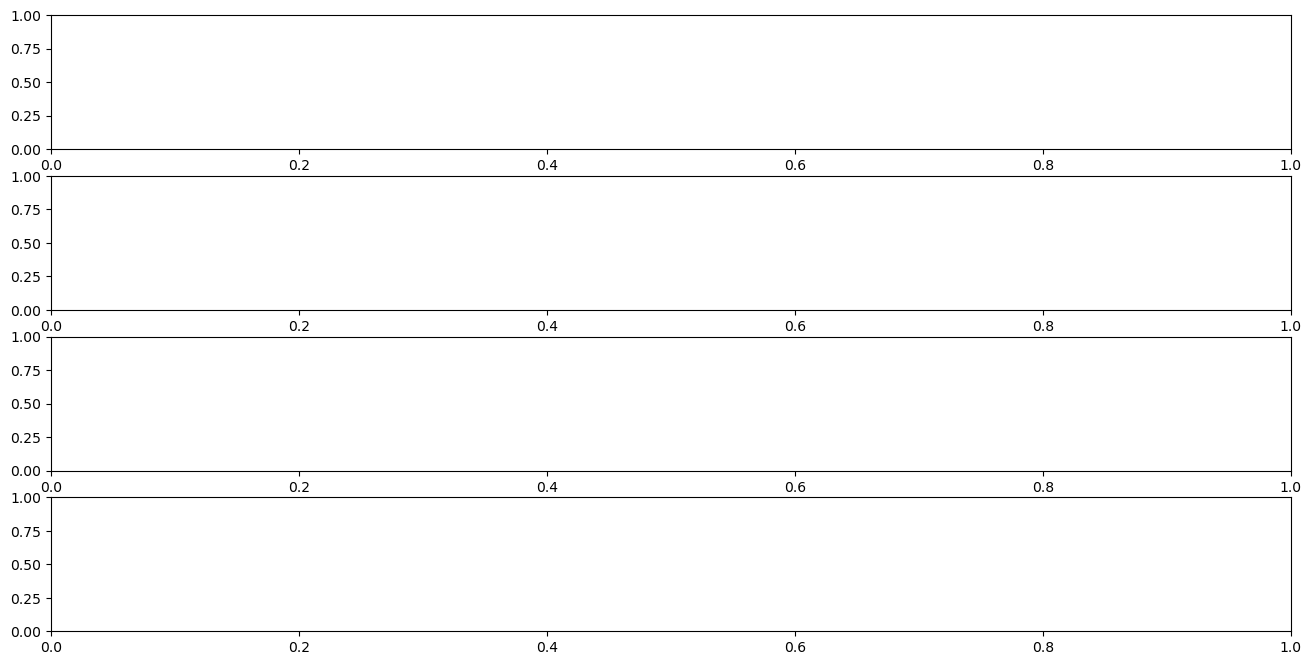

In [6]:
res = seasonal_decompose(df['count'].values, period=24)
res.observed
res.trend
res.seasonal
res.resid

fig, axs = plt.subplots(4, figsize=(16, 8))
axs

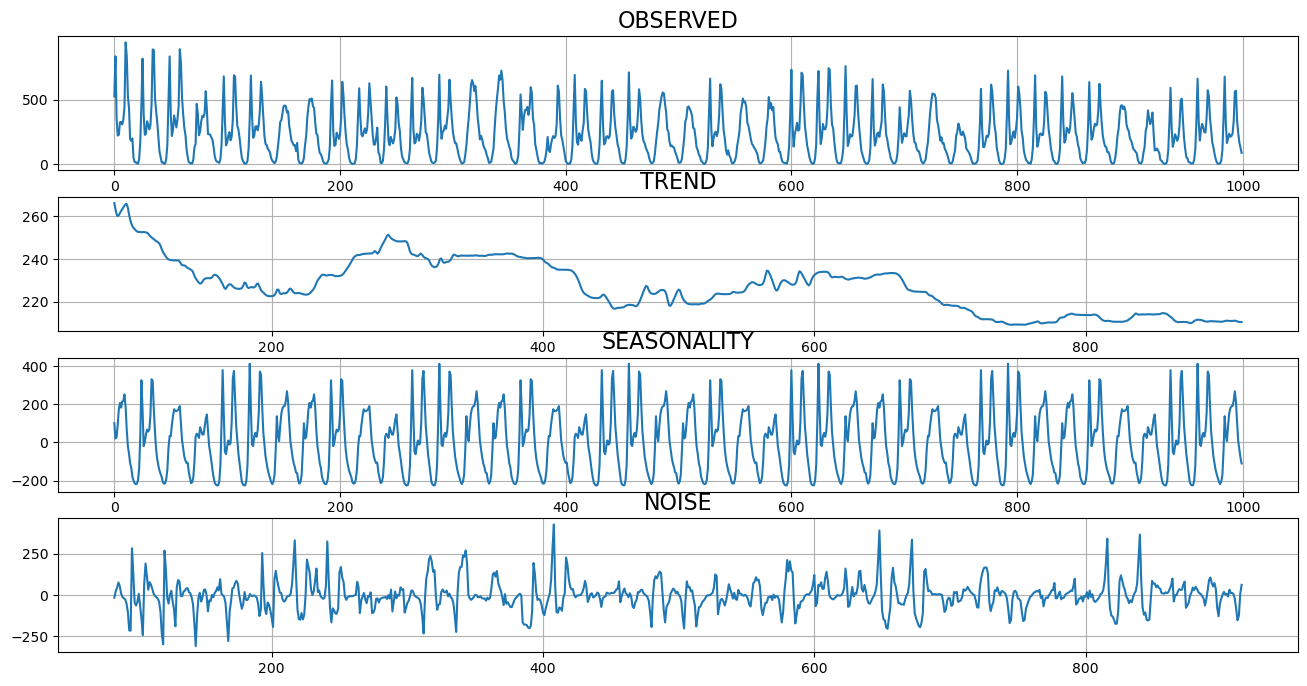

In [7]:
def decompose_bike_sharing_demand(df, share_type='count', sample=250, period=24):
    if sample == 'all':
        # decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        # decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-sample:], period=period)
        
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    # plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16, 8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    # plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    # plot the seasonality of the time series. Period=24 daily seasonality or period=24*7 weekly seasonality
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    # plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].grid()
    
    plt.show()
    
decompose_bike_sharing_demand(df, sample=1000, period=24*7)

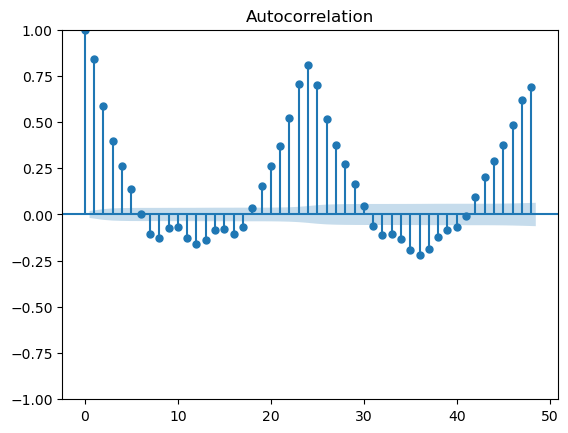

In [8]:
plot_acf(df['count'].values, lags=48)
plt.show()

In [10]:
# convert datatime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# set datetime as index
df = df.set_index(df.datetime)

# drop datetime column
df.drop('datetime', axis=1, inplace=True)

# create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month


# drop casual and registered columns
df.drop(['casual', 'registered'], axis = 1, inplace=True)

df.head(5)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


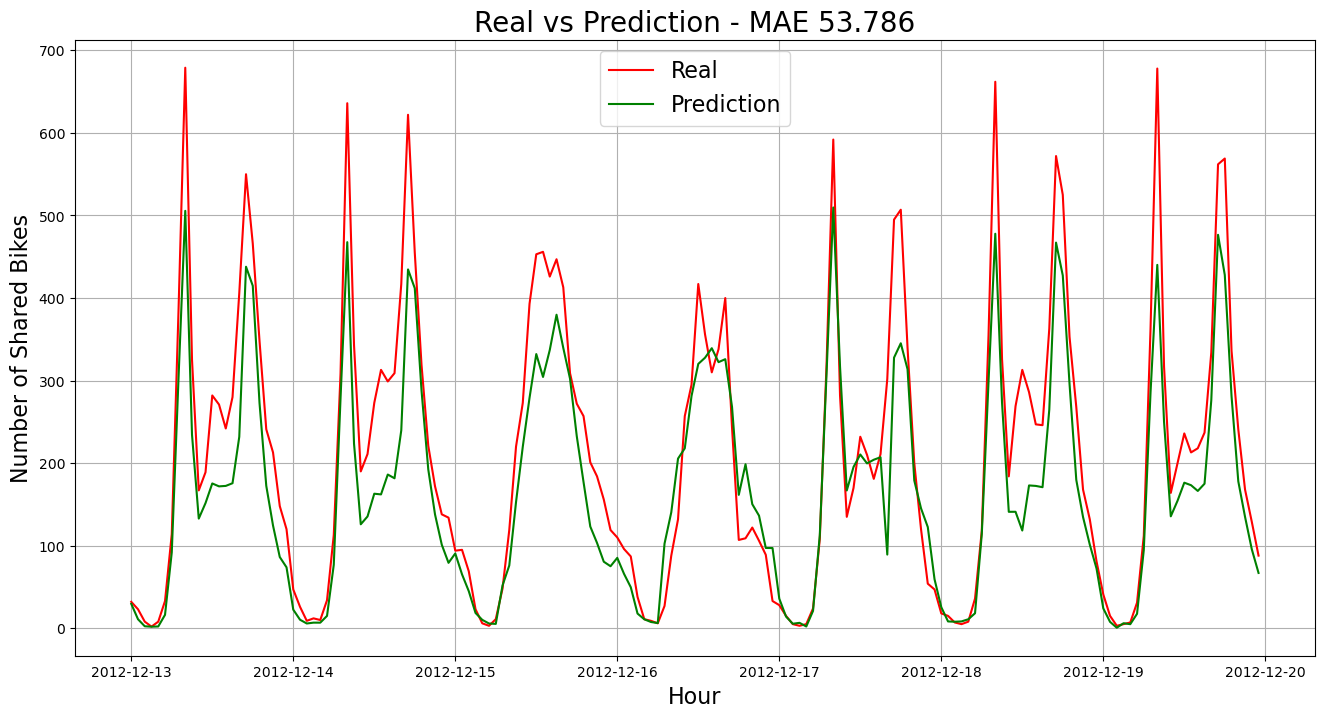

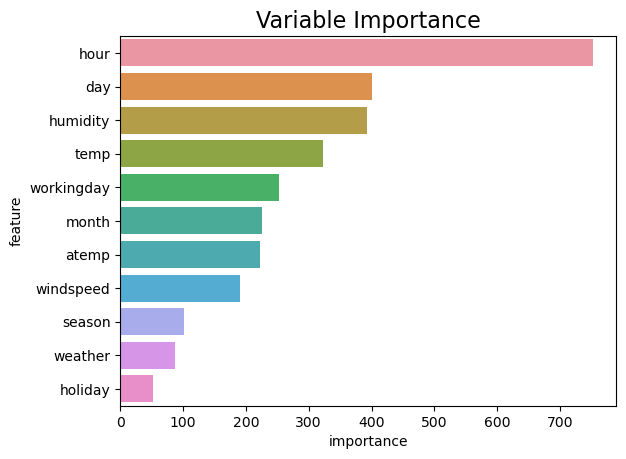

In [24]:
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('count', axis=1)
    y = df['count']
    
    # take last week or the dateset for validation
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red') # index is datetime
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    # create a dateframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature':model.feature_name_,
        'importance':model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    plt.title('Variable Importance', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()
    
train_time_series_with_folds(df)

In [36]:
#df['count'].shift(1)

datetime
2011-01-15 12:00:00      NaN
2011-01-15 13:00:00     89.0
2011-01-15 14:00:00    101.0
2011-01-15 15:00:00    118.0
2011-01-15 16:00:00    129.0
                       ...  
2012-12-19 19:00:00    569.0
2012-12-19 20:00:00    336.0
2012-12-19 21:00:00    241.0
2012-12-19 22:00:00    168.0
2012-12-19 23:00:00    129.0
Name: count, Length: 10550, dtype: float64

In [31]:
# create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['count'].shift(24*7)

# drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

df.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,count_prev_week_same_hour
datetime,,,,,,,,,,,,,
2011-01-15 12:00:00,1,0,0,1,9.84,11.365,48,15.0013,89,12,15,1,9.0
2011-01-15 13:00:00,1,0,0,1,11.48,12.880,38,19.9995,101,13,15,1,15.0
2011-01-15 14:00:00,1,0,0,1,12.30,14.395,39,19.0012,118,14,15,1,20.0
2011-01-15 15:00:00,1,0,0,2,13.12,15.910,36,12.9980,129,15,15,1,61.0
2011-01-15 16:00:00,1,0,0,2,13.94,16.665,34,12.9980,128,16,15,1,62.0


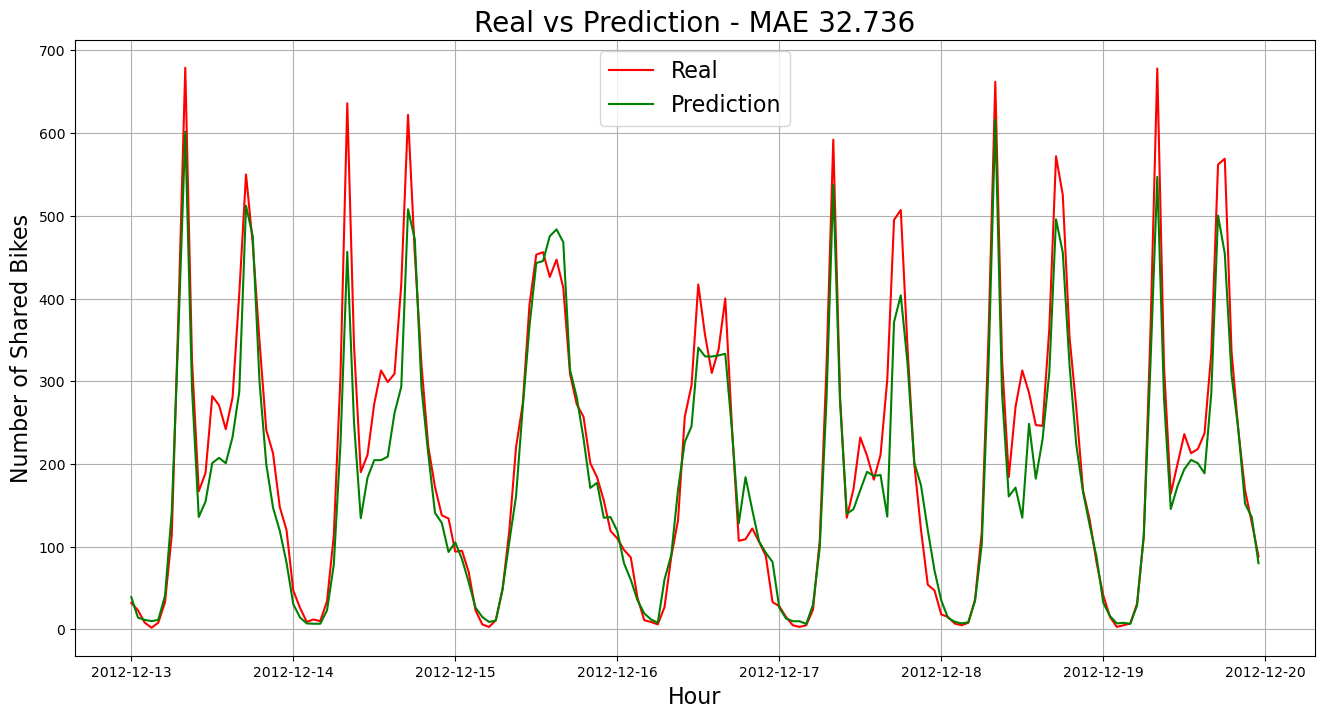

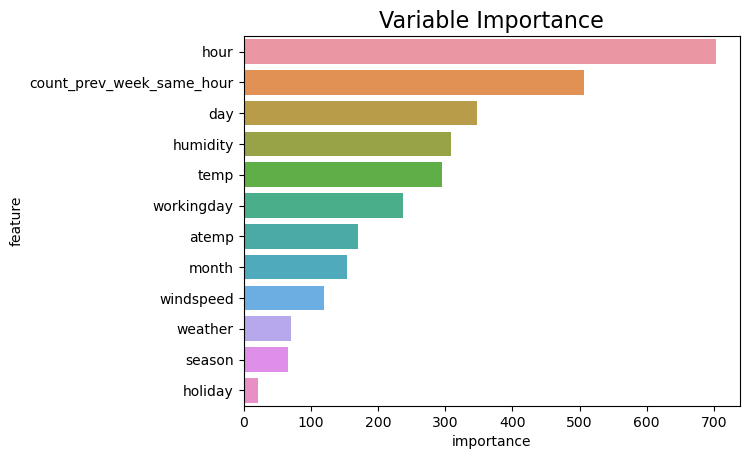

In [30]:
train_time_series_with_folds(df)